## For plotting Confusion Matrix

In [28]:
import numpy as np
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook 
from sklearn.preprocessing import OneHotEncoder
from numpy.linalg import norm

In [29]:
np.random.seed(0)

In [30]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()
x_train = x_train.astype('float')/ 255.0
x_test = x_test.astype('float')/ 255.0
print(x_train.shape, x_test.shape,y_train.shape,y_test.shape,type(x_train[0][0]),x_train[0][0])
x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)
print(x_train.shape, x_test.shape,y_train.shape,y_test.shape,type(x_train[0][0]),x_train[0][0])

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,) <class 'numpy.ndarray'> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(60000, 784) (10000, 784) (60000,) (10000,) <class 'numpy.float64'> 0.0


In [31]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1,stratify=y_train, random_state=0)
print(x_train.shape, x_test.shape,y_train.shape,y_test.shape,type(x_train[0][0]),x_train[0][0])

(54000, 784) (6000, 784) (54000,) (6000,) <class 'numpy.float64'> 0.0


In [32]:
print(x_train.dtype) #arr = arr.astype('float128')

float64


In [33]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(y_test,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(54000, 10) (6000, 10)


In [38]:
!pip install wandb --upgrade
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [40]:
class FFSN_MultiClass:
  
  def __init__(self, n_inputs, n_outputs, noof_hidden, size_of_every_hidden, 
               init_method = 'random', activation_function = 'sigmoid'):
    hidden_sizes=[]
    for i in range(noof_hidden):
        hidden_sizes.append(size_of_every_hidden)
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    self.activation_function = activation_function

    self.W = {}
    self.B = {}
    np.random.seed(0)

    if init_method == "random":
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.random.randn(1, self.sizes[i+1])
    elif init_method == "xavier":
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])*np.sqrt(1/self.sizes[i])
        self.B[i+1] = np.random.randn(1, self.sizes[i+1])
    elif init_method == "he":
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])*np.sqrt(2/self.sizes[i])
        self.B[i+1] = np.random.randn(1, self.sizes[i+1])

  def forward_activation(self, X): 
    if self.activation_function == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "relu":
      return np.maximum(0,X)
    elif self.activation_function == "leaky_relu":
      return np.maximum(self.leaky_slope*X,X)
      
  def grad_activation(self, X):
    if self.activation_function == "sigmoid":
      return X*(1-X) 
    elif self.activation_function == "tanh":
      return (1-np.square(X))
    elif self.activation_function == "relu":
      return 1.0*(X>0)
    elif self.activation_function == "leaky_relu":
      d=np.zeros_like(X)
      d[X<=0]=self.leaky_slope
      d[X>0]=1
      return d
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps, axis=1).reshape(-1,1) 

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.forward_activation(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
 
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = np.sum(self.dA[k],axis=0).reshape(1,-1)
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_activation(self.H[k-1])) 
    
  def fit(self, X, Y, epochs=100, algo= "GD", learning_rate=0.01, display_loss=True,
          mini_batch_size=60000, eps=1e-8, beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9,lambda_val=0.5,l2_norm=True):
      
    if display_loss:
      loss = {}
    V_W = {}
    V_B = {}
    M_W = {}
    M_B = {}
    num_updates = 0
    for i in range(self.nh+1):
      V_W[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
      V_B[i+1] = np.zeros((1, self.sizes[i+1]))
      M_W[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
      M_B[i+1] = np.zeros((1, self.sizes[i+1]))
    if algo == 'SGD':
        for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
          points_seen = 0
          m = X.shape[0]
          mini_batch_size=1
          while(points_seen<X.shape[0]):
            self.grad(X[points_seen:points_seen+mini_batch_size,:], Y[points_seen:points_seen+mini_batch_size,:])
            for i in range(self.nh+1):
              if l2_norm:
                self.W[i+1] -= (learning_rate * lambda_val)/m * self.W[i+1] + learning_rate * (self.dW[i+1]/m)
              else:
                self.W[i+1] -= learning_rate * (self.dW[i+1]/m)
              self.B[i+1] -= learning_rate * (self.dB[i+1]/m)
            points_seen=points_seen+mini_batch_size
            
          if display_loss:
            Y_pred = self.predict(X) 
            loss[epoch] = self.cross_entropy(Y, Y_pred)
          Y_pred_train = self.predict(x_train)
          train_loss = self.cross_entropy(y_OH_train, Y_pred_train)
          Y_pred_train = np.argmax(Y_pred_train,1)

          Y_pred_val = self.predict(x_test)
          test_loss = self.cross_entropy(y_OH_val, Y_pred_val)
          Y_pred_val = np.argmax(Y_pred_val,1)


          accuracy_train = accuracy_score(Y_pred_train, y_train)
          accuracy_val = accuracy_score(Y_pred_val, y_test)
          #print(accuracy_train,accuracy_val)
          '''wandb.log({"val_accuracy": accuracy_val,"val_loss": test_loss, 
               "loss": train_loss,"epochs": epoch+1, "accuracy": accuracy_train})'''
    
    
    if algo == 'Momentum':
      for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
        points_seen = 0
        m = mini_batch_size
        while(points_seen<X.shape[0]):
          self.grad(X[points_seen:points_seen+mini_batch_size,:], Y[points_seen:points_seen+mini_batch_size,:])
          for i in range(self.nh+1):
            V_W[i+1] = gamma * V_W[i+1] + learning_rate * (self.dW[i+1]/m)
            V_B[i+1] = gamma * V_B[i+1] + learning_rate * (self.dB[i+1]/m)
                    
          for i in range(self.nh+1):
            if l2_norm:
              self.W[i+1] -= (learning_rate * lambda_val)/m * self.W[i+1] + V_W[i+1]
            else:
              self.W[i+1] -= V_W[i+1]
            self.B[i+1] -= V_B[i+1]
          points_seen=points_seen+mini_batch_size
            
        if display_loss:
          Y_pred = self.predict(X) 
          loss[epoch] = self.cross_entropy(Y, Y_pred)
        Y_pred_train = self.predict(x_train)
        train_loss = self.cross_entropy(y_OH_train, Y_pred_train)
        Y_pred_train = np.argmax(Y_pred_train,1)

        Y_pred_val = self.predict(x_test)
        test_loss = self.cross_entropy(y_OH_val, Y_pred_val)
        Y_pred_val = np.argmax(Y_pred_val,1)


        accuracy_train = accuracy_score(Y_pred_train, y_train)
        accuracy_val = accuracy_score(Y_pred_val, y_test)
        #print(accuracy_train,accuracy_val)
        '''wandb.log({"val_accuracy": accuracy_val,"val_loss": test_loss, 
               "loss": train_loss,"epochs": epoch+1, "accuracy": accuracy_train})'''

    if algo == 'NAG':
      for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
        points_seen = 0
        m = mini_batch_size
        for i in range(self.nh+1):
          self.W[i+1] -= gamma*V_W[i+1]
          self.B[i+1] -= gamma*V_B[i+1]
        while(points_seen<X.shape[0]):
          self.grad(X[points_seen:points_seen+mini_batch_size,:], Y[points_seen:points_seen+mini_batch_size,:])
          for i in range(self.nh+1):
            self.W[i+1] -= learning_rate * (self.dW[i+1]/m)
            self.B[i+1] -= learning_rate * (self.dB[i+1]/m)
          for i in range(self.nh+1):
            V_W[i+1] = gamma*V_W[i+1] + learning_rate * (self.dW[i+1]/m)
            V_B[i+1] = gamma*V_B[i+1] + learning_rate * (self.dB[i+1]/m)
            if l2_norm:
              self.W[i+1] -= (learning_rate * lambda_val)/m * self.W[i+1] + gamma*V_W[i+1]
            else:
              self.W[i+1] -= gamma*V_W[i+1]
            self.B[i+1] -= gamma*V_B[i+1]
          points_seen=points_seen+mini_batch_size

        if display_loss:
          Y_pred = self.predict(X) 
          loss[epoch] = self.cross_entropy(Y, Y_pred)  
        Y_pred_train = self.predict(x_train)
        train_loss = self.cross_entropy(y_OH_train, Y_pred_train)
        Y_pred_train = np.argmax(Y_pred_train,1)

        Y_pred_val = self.predict(x_test)
        test_loss = self.cross_entropy(y_OH_val, Y_pred_val)
        Y_pred_val = np.argmax(Y_pred_val,1)


        accuracy_train = accuracy_score(Y_pred_train, y_train)
        accuracy_val = accuracy_score(Y_pred_val, y_test)
        #print(accuracy_train,accuracy_val)
        '''wandb.log({"val_accuracy": accuracy_val,"val_loss": test_loss, 
               "loss": train_loss,"epochs": epoch+1, "accuracy": accuracy_train})'''

    if algo == 'RMSProp':
      for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
        points_seen = 0
        m = mini_batch_size
        while(points_seen<X.shape[0]):
          self.grad(X[points_seen:points_seen+mini_batch_size,:], Y[points_seen:points_seen+mini_batch_size,:])
          for i in range(self.nh+1):
            V_W[i+1] = beta*V_W[i+1] + (1-beta) * ((self.dW[i+1]/m)**2)
            V_B[i+1] = beta*V_B[i+1] + (1-beta) * ((self.dB[i+1]/m)**2)
          for i in range(self.nh+1):
            if l2_norm:
              self.W[i+1] -= (learning_rate * lambda_val)/m * self.W[i+1] + (learning_rate / np.sqrt(V_W[i+1]+ eps))* (self.dW[i+1]/m)
            else:
              self.W[i+1] -= (learning_rate / np.sqrt(V_W[i+1]+ eps))* (self.dW[i+1]/m)
            self.B[i+1] -= (learning_rate / np.sqrt(V_B[i+1]+ eps))* (self.dB[i+1]/m)
          points_seen=points_seen+mini_batch_size
        
        if display_loss:
          Y_pred = self.predict(X) 
          loss[epoch] = self.cross_entropy(Y, Y_pred)
        Y_pred_train = self.predict(x_train)
        train_loss = self.cross_entropy(y_OH_train, Y_pred_train)
        Y_pred_train = np.argmax(Y_pred_train,1)

        Y_pred_val = self.predict(x_test)
        test_loss = self.cross_entropy(y_OH_val, Y_pred_val)
        Y_pred_val = np.argmax(Y_pred_val,1)


        accuracy_train = accuracy_score(Y_pred_train, y_train)
        accuracy_val = accuracy_score(Y_pred_val, y_test)
        #print(accuracy_train,accuracy_val)
        '''wandb.log({"val_accuracy": accuracy_val,"val_loss": test_loss, 
               "loss": train_loss,"epochs": epoch+1, "accuracy": accuracy_train})'''

    if algo == 'Adam':
      for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
        points_seen = 0
        m = mini_batch_size
        while(points_seen<X.shape[0]):
          self.grad(X[points_seen:points_seen+mini_batch_size,:], Y[points_seen:points_seen+mini_batch_size,:])
          for i in range(self.nh+1):
            num_updates += 1
            M_W[i+1] = beta1*M_W[i+1] + (1-beta1) * (self.dW[i+1]/m)
            M_B[i+1] = beta1*M_B[i+1] + (1-beta1) * (self.dB[i+1]/m)
            V_W[i+1] = beta2*V_W[i+1] + (1-beta2) * ((self.dW[i+1]/m)**2)
            V_B[i+1] = beta2*V_B[i+1] + (1-beta2) * ((self.dB[i+1]/m)**2)
            M_W_C = M_W[i+1] / (1 - np.power(beta1, num_updates))
            M_B_C = M_B[i+1] / (1 - np.power(beta1, num_updates))
            V_W_C = V_W[i+1] / (1 - np.power(beta2, num_updates))
            V_B_C = V_B[i+1] / (1 - np.power(beta2, num_updates))
            if l2_norm:
              self.W[i+1] -= (learning_rate * lambda_val)/m * self.W[i+1] + (learning_rate / np.sqrt(V_W_C + eps))* M_W_C
            else:
              self.W[i+1] -= (learning_rate / np.sqrt(V_W_C + eps))* M_W_C
            self.B[i+1] -= (learning_rate / np.sqrt(V_B_C + eps)) * M_B_C
          points_seen=points_seen+mini_batch_size
        
        if display_loss:
          Y_pred = self.predict(X) 
          loss[epoch] = self.cross_entropy(Y, Y_pred)
        Y_pred_train = self.predict(x_train)
        train_loss = self.cross_entropy(y_OH_train, Y_pred_train)
        Y_pred_train = np.argmax(Y_pred_train,1)

        Y_pred_val = self.predict(x_test)
        test_loss = self.cross_entropy(y_OH_val, Y_pred_val)
        Y_pred_val = np.argmax(Y_pred_val,1)


        accuracy_train = accuracy_score(Y_pred_train, y_train)
        accuracy_val = accuracy_score(Y_pred_val, y_test)
        #print(accuracy_train,accuracy_val)
        '''wandb.log({"val_accuracy": accuracy_val,"val_loss": test_loss, 
               "loss": train_loss,"epochs": epoch+1, "accuracy": accuracy_train})'''
    if algo == 'Nadam':
      for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
        points_seen = 0
        m = mini_batch_size
        while(points_seen<X.shape[0]):
          num_updates += 1
          self.grad(X[points_seen:points_seen+mini_batch_size,:], Y[points_seen:points_seen+mini_batch_size,:])
          for i in range(self.nh+1):
            M_W[i+1] = beta1*M_W[i+1] + (1-beta1) * (self.dW[i+1]/m)
            M_B[i+1] = beta1*M_B[i+1] + (1-beta1) * (self.dB[i+1]/m)
            V_W[i+1] = beta2*V_W[i+1] + (1-beta2) * ((self.dW[i+1]/m)**2)
            V_B[i+1] = beta2*V_B[i+1] + (1-beta2) * ((self.dB[i+1]/m)**2)
            M_W_C = M_W[i+1] / (1 - np.power(beta1, num_updates))
            M_B_C = M_B[i+1] / (1 - np.power(beta1, num_updates))
            V_W_C = V_W[i+1] / (1 - np.power(beta2, num_updates))
            V_B_C = V_B[i+1] / (1 - np.power(beta2, num_updates))
            if l2_norm:
              self.W[i+1] -= (learning_rate * lambda_val)/m * self.W[i+1] + (learning_rate / np.sqrt(V_W_C + eps))* (beta1*M_W_C + (1-beta1)/(1-np.power(beta1,num_updates))* (self.dW[i+1]/m))
            else:
              self.W[i+1] -= (learning_rate / np.sqrt(V_W_C + eps))* (beta1*M_W_C + (1-beta1)/(1-np.power(beta1,num_updates))* (self.dW[i+1]/m) )
            self.B[i+1] -= (learning_rate / np.sqrt(V_B_C + eps)) * (beta1*M_B_C + (1-beta1)/(1-np.power(beta1,num_updates))* (self.dB[i+1]/m))
          points_seen=points_seen+mini_batch_size
        
        if display_loss:
          Y_pred = self.predict(X) 
          loss[epoch] = self.cross_entropy(Y, Y_pred)
        Y_pred_train = self.predict(x_train)
        train_loss = self.cross_entropy(y_OH_train, Y_pred_train)
        Y_pred_train = np.argmax(Y_pred_train,1)

        Y_pred_val = self.predict(x_test)
        test_loss = self.cross_entropy(y_OH_val, Y_pred_val)
        Y_pred_val = np.argmax(Y_pred_val,1)


        accuracy_train = accuracy_score(Y_pred_train, y_train)
        accuracy_val = accuracy_score(Y_pred_val, y_test)
        #print(accuracy_train,accuracy_val)
        '''wandb.log({"val_accuracy": accuracy_val,"val_loss": test_loss, 
               "loss": train_loss,"epochs": epoch+1, "accuracy": accuracy_train})'''
    
    if display_loss:
        plt.plot(np.array(list(loss.values())).astype(float))
        plt.xlabel('Epochs')
        plt.ylabel('CE')
        plt.show()
    print(accuracy_train,accuracy_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:298: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10 [00:00<?, ?epoch/s]

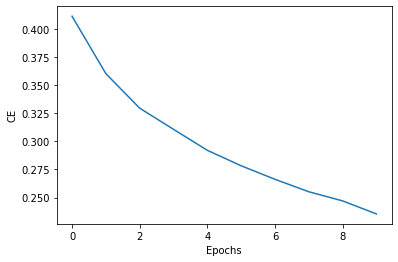

0.9130555555555555 0.8921666666666667


In [41]:
ffsn_multi = FFSN_MultiClass(784,10,3,128,init_method='he', activation_function='relu')
ffsn_multi.fit(x_train,y_OH_train,epochs=10,learning_rate=0.0005,algo= "Nadam",mini_batch_size=128,lambda_val=0.0005)

## Confustion Matrix

wandb: Currently logged in as: cs21m009 (use `wandb login --relogin` to force relogin)


Training accuracy 0.91
Validation accuracy 0.89


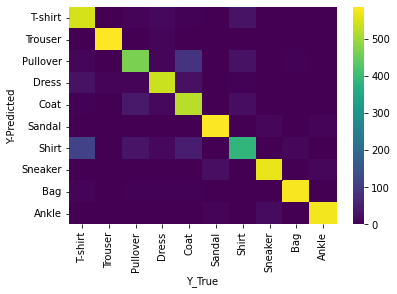

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle']
Y_pred_train = ffsn_multi.predict(x_train)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_val = ffsn_multi.predict(x_test)
Y_pred_val = np.argmax(Y_pred_val,1)


accuracy_train = accuracy_score(Y_pred_train, y_train)
accuracy_val = accuracy_score(Y_pred_val, y_test)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

wandb.init(project="DL 1.1", entity="cs21m009",name='plotting_confusion_matrix')
table = pd.DataFrame(confusion_matrix(y_test,Y_pred_val),columns=class_names,index=class_names)
con_mat=sns.heatmap(table,annot=False,fmt='d',cmap='viridis')
con_mat.set(xlabel='Y_True', ylabel='Y-Predicted')
con_mat
wandb.log({"Confusion_Matrix ":[wandb.Image(con_mat, caption='y_true')]})
wandb.log({"conf_mat" : wandb.sklearn.plot_confusion_matrix(y_test,Y_pred_val,class_names,)})

In [ ]:
'''
reasons :
increasing learning rate will lead to fluctuations in the epochs vs loss curve
'''